In [5]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import random
import pickle as pkl
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

In [51]:
class Linear(layers.Layer):
    '''
    Class for initializing a layer in Neural Network
    '''
    def __init__(self, units=32):
        '''
        constructor
        :param units: number of nodes in the layer
        '''
        super(Linear, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        '''
        Initialize weight and bias values of the layer
        :param w: weights
        :param b: bias
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        '''
        layer output
        '''
        return tf.matmul(inputs, self.w) + self.b

In [2]:
class DPN(layers.Layer):
    def __init__(self, tau_value=0):
        super(DPN, self).__init__()
        self.tau = tau_value
        self.layers = []
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(312))
        self.layers.append(Linear(784))
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))
        
    def call(self, inputs):
        Z0 = self.layers[0](inputs)
        Z1 = tf.nn.sigmoid(Z0)
        Z2 = self.layers[1](Z1)
        Z2 = tf.nn.sigmoid(Z2)
        Z1_hat = self.layers[2](Z2)
        Z1_hat = tf.nn.sigmoid(Z1_hat)
        Z0_hat = self.layers[3](Z1)
        Z0_hat = tf.nn.sigmoid(Z0_hat)
        
        l0 = self.layers[4](inputs)
        l1 = tf.nn.tanh(l0) * (self.tau * Z1 + (1-self.tau))
        l2 = self.layers[5](l1)
        l2 = tf.nn.tanh(l2) * (self.tau * Z2 + (1-self.tau)) 
        y = self.layers[6](l2)
        y = tf.nn.sigmoid(y)
        
        # Calculating layer wise KL-Divergence using 'sum' reduction type.
#         mse = tf.keras.losses.MeanSquaredError()
#         loss = mse(inputs, Z0_hat) + mse(Z1, Z1_hat)
        loss = custom_bce(Z0_hat, inputs) + custom_bce(Z1_hat, Z1)
#         loss = custom_KLD(Z0_hat, inputs) + custom_KLD(Z1_hat, Z1)
#         kld = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
#         loss = kld(inputs, Z0_hat) + kld(Z1, Z1_hat)
        
        return y, loss
    
    def get_layers(self):
        trainable_wts = []
        for layer in self.layers:
            trainable_wts.extend(layer.trainable_weights)
        return trainable_wts

In [17]:
class Network():
    
    def __init__(self, n_x, n_z1, n_z2, n_y):
        self.params = []
        self.m1 = tf.Variable(tf.random.normal([n_x, n_z1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='M1')
        self.n1 = tf.Variable(tf.random.normal([1, n_z1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='n1')
        self.m2 = tf.Variable(tf.random.normal([n_z1, n_z2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='M2')
        self.n2 = tf.Variable(tf.random.normal([1, n_z2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='n2')
        self.m21 = tf.Variable(tf.random.normal([n_z2, n_z1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='M21')
        self.n21 = tf.Variable(tf.random.normal([1, n_z1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='n21')
        self.m10 = tf.Variable(tf.random.normal([n_z1, n_x], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='M10')
        self.n10 = tf.Variable(tf.random.normal([1, n_x], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='n10')
        
        # now declare the weights connecting the input to the hidden layer
        self.W1 = tf.Variable(tf.random.normal([n_x, n_z1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='W1')
        self.b1 = tf.Variable(tf.random.normal([1, n_z1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='b1')
        self.W2 = tf.Variable(tf.random.normal([n_z1, n_z2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='W2')
        self.b2 = tf.Variable(tf.random.normal([1, n_z2], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='b2')
        self.W3 = tf.Variable(tf.random.normal([n_z2, n_y], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='W3')
        self.b3 = tf.Variable(tf.random.normal([1, n_y], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0),  name='b3')
        
        self.params.append(self.m1)
        self.params.append(self.n1)
        self.params.append(self.m2)
        self.params.append(self.n2)
        self.params.append(self.m21)
        self.params.append(self.n21)
        self.params.append(self.m10)
        self.params.append(self.n10)
        
        self.params.append(self.W1)
        self.params.append(self.b1)
        self.params.append(self.W2)
        self.params.append(self.b2)
        self.params.append(self.W3)
        self.params.append(self.b3)
        
    def forward(self, x, tau = 0.0):
        Z1 = tf.matmul(x, self.m1) + self.n1
        Z1 = tf.nn.sigmoid(Z1)
        Z2 = tf.matmul(Z1, self.m2) + self.n2
        Z2 = tf.nn.sigmoid(Z2)
        Z1_hat = tf.matmul(Z2, self.m21) + self.n21
        Z1_hat = tf.nn.sigmoid(Z1_hat)
        Z0_hat = tf.matmul(Z1, self.m10) + self.n10
        Z0_hat = tf.nn.sigmoid(Z0_hat)
        
        H1 = tf.matmul(x, self.W1) + self.b1
        H1 = tf.nn.relu(H1) * (tau * Z1 + (1-tau))
        H2 = tf.matmul(H1, self.W2) + self.b2
        H2 = tf.nn.relu(H2) * (tau * Z2 + (1-tau))
        Y = tf.matmul(H2, self.W3) + self.b3
        Y = tf.nn.sigmoid(Y)
        
        at_loss = custom_bce(Z0_hat, x) + custom_bce(Z1_hat, Z1)

        return Y, at_loss
    
    def loss(self, y_true, y_pred):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, 1)), dtype=tf.float32)
        y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, 1)), dtype=tf.float32)
        return tf.reduce_mean(tf.compat.v1.losses.log_loss(y_true_tf, y_pred))
    
    def backward(self, x, y):
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
        with tf.GradientTape() as tape:
            predicted, autoencoder_loss = self.forward(x)
            current_loss = self.loss(y, predicted) + (tau * autoencoder_loss + (1-tau))
        grads = tape.gradient(current_loss, self.params)
        optimizer.apply_gradients(zip(grads, self.params),
                                  global_step=tf.compat.v1.train.get_or_create_global_step())


def custom_bce(p, y, offset=1e-7): #1e-10
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = -tf.reduce_mean(y * tf.math.log(p_) + (1.0 - y) * tf.math.log(1.0 - p_), axis=1)
    return tf.reduce_mean(vec_bce)/y.shape[0]

def custom_KLD(q, p, offset=1e-7): # q is model predictive/approximating distribution, p is target distribution
    q_ = tf.clip_by_value(q, offset, 1 - offset)
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = tf.reduce_sum(p_ * (tf.math.log(p_) - tf.math.log(q_)))
    return tf.reduce_sum(vec_bce)/p.shape[0]

def relabel(labels):
    '''
    task wise relabel the dataset as combination of 0's and 1's
    '''
    new_labels = np.empty((0, labels.shape[0]), dtype=np.float32)
    for task in range(10):
        positives = np.where(labels[:,task] == 1)[0]
        task_labels = np.zeros(labels.shape[0], dtype=np.float32)
        task_labels[positives] = 1.0
        new_labels = np.vstack((new_labels, task_labels))
#     new_labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    return new_labels

def batch_loader(labels, batch_size, class_bal=False):
    '''
    load random batches of data
    '''
    # if class balance is not required in every batch
    if not class_bal:
        indices = np.arange(labels.shape[0])
        for _ in range(5): np.random.shuffle(indices)
        batches = np.asarray(list(divide_chunks(indices, batch_size)))
        return batches
    
    # if class balance is needed in every batch
    else:
        positives = np.where(labels==1)[0]
        negatives = np.arange(labels.shape[0])
        negatives = np.delete(negatives, positives)
        np.random.shuffle(negatives)
        np.random.shuffle(positives)
        task_batch = []
        # create batches by iteratively scraping out chunks out of positives array
        while positives.shape[0] > 0:
            if len(positives) >= batch_size/2:
                # create a batch such that positive (batch_size/2) is added with sampled negatives (batch_size/2)
                temp = np.concatenate((positives[:batch_size//2], np.random.choice(negatives, batch_size//2)))
                positives = positives[batch_size//2: ]
            else:
                # for the last batch where no. of positive could be < batch_size
                temp = np.concatenate((positives, np.random.choice(negatives, len(positives))))
                positives = np.array([])
            np.random.shuffle(temp)
            task_batch.append(temp)
        return np.asarray(task_batch)

trainX = pd.read_csv('datasets/mnist/trainX.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
trainY = pd.read_csv('datasets/mnist/trainY.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
testX = pd.read_csv('datasets/mnist/testX.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
testY = pd.read_csv('datasets/mnist/testY.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
validX = pd.read_csv('datasets/mnist/validX.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
validY = pd.read_csv('datasets/mnist/validY.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()

trainY = relabel(trainY)
testY = relabel(testY)
validY = relabel(validY)

optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
# bce = tf.keras.losses.BinaryCrossentropy()
# net = MLPBlock()
# autoencoder = NTBlock()
# dpn = DPN(tau_value=0)
net = Network(784, 312, 128, 1)
n_tasks = 2
n_epochs = 5
tau = 0

# declare array for collecting train loss
# train_losses[t] = [n_epochs x n_tasks]
train_losses = {}
test_losses = {}
valid_losses = {}
train_accuracy = {}
valid_accuracy = {}
test_accuracy = {}
train_autoencoder_loss = {}
valid_autoencoder_loss = {}
test_autoencoder_loss = {}
for t in range(n_tasks):
    train_losses[t] = []
    valid_losses[t] = []
    train_accuracy[t] = []
    valid_accuracy[t] = []
    test_losses[t] = []
    test_accuracy[t] = []
    train_autoencoder_loss[t] = []
    valid_autoencoder_loss[t] = []
    test_autoencoder_loss[t] = []

def train_metrics():
    for t in range(n_tasks):
        loss = 0
        train_acc = 0
        loss_at = 0
        size = 0
        batches = batch_loader(trainY[t], 50, class_bal=True)
        for batch in batches:
            output, autoencoder_loss = net.forward(trainX[batch])
#                 reconstructed_x, autoencoder_loss = autoencoder(trainX[batch], calc_loss=True)
#                 print('task %s= output:' % (task, output))
            size += batch.shape[0]
            temp = tf.convert_to_tensor(trainY[t, batch].reshape(output.shape), dtype=tf.float32)
#             loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
            loss += (net.loss(temp, output) + (tau*autoencoder_loss + (1-tau))) * batch.shape[0]
            loss_at += autoencoder_loss * batch.shape[0]
            output = output.numpy().reshape(-1)
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            train_acc += np.sum(output == trainY[t, batch])
            break
            
        train_losses[t].append(loss/size)
        train_accuracy[t].append(train_acc/size)
        train_autoencoder_loss[t].append(loss_at/size)
        
def valid_metrics():
    for t in range(n_tasks):
        valid_loss = 0
        valid_acc = 0
        loss_at = 0
        size = 0            
        batches = batch_loader(validY[t], 50, class_bal=True)
        for batch in batches:
            output, autoencoder_loss = net.forward(validX[batch])
            size += batch.shape[0]
            temp = tf.convert_to_tensor(validY[t, batch].reshape(output.shape), dtype=tf.float32)
#             valid_loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
            valid_loss += (net.loss(temp, output) + (tau*autoencoder_loss + (1-tau))) * batch.shape[0]
            loss_at += autoencoder_loss * batch.shape[0]
            output = output.numpy().reshape(-1)
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            valid_acc += np.sum(output == validY[t, batch])
            break
            
        valid_losses[t].append(valid_loss/size)
        valid_accuracy[t].append(valid_acc/size)
        valid_autoencoder_loss[t].append(loss_at/size)

train_metrics()
valid_metrics()

# train and calculate BWT, FWT
tqdm.write('Tasks running')
for task in tqdm(range(n_tasks)):
    tqdm.write('Epochs running')
    for epoch in tqdm(range(n_epochs)):
        total_loss = 0
        batches = batch_loader(trainY[task], 50, class_bal=True)
        for batch in batches:
            preds, autoencoder_loss = net.forward(trainX[batch])
            batch_loss = (net.loss(trainY[task, batch], preds) + (tau * autoencoder_loss + (1-tau))) * batch.shape[0]
            net.backward(trainX[batch], trainY[task, batch])
#             with tf.GradientTape() as tape:
#                 output, autoencoder_loss = net.forward(trainX[batch])
#                 temp = tf.convert_to_tensor(trainY[task, batch].reshape(output.shape), dtype=tf.float32)
#                 batch_loss = custom_bce(output, temp) + tau*autoencoder_loss
# #             weights = dpn.get_layers()
#             grads = tape.gradient(batch_loss, net.params)
#             optimizer.apply_gradients(zip(grads, net.params))

        train_metrics()
        valid_metrics()
            
#         print('----- epoch %s completed -----' % (epoch))

#     print('--------------------- Task %s completed ---------------------' % task)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Tasks running
Epochs running



  0%|          | 0/5 [00:00<?, ?it/s]

Epochs running



100%|██████████| 2/2 [00:44<00:00, 22.26s/it]


In [20]:
for t in range(n_tasks):
    test_loss = 0
    test_acc = 0
    loss_at = 0
    size = 0            
    batches = batch_loader(testY[t], 50, class_bal=True)
    for batch in batches:
        output, autoencoder_loss = net.forward(testX[batch])
        size += batch.shape[0]
        temp = tf.convert_to_tensor(testY[t, batch].reshape(output.shape), dtype=tf.float32)
#         test_loss += (custom_bce(output, temp) + autoencoder_loss) * batch.shape[0]
        test_loss += (net.loss(temp, output) + (tau * autoencoder_loss + (1-tau))) * batch.shape[0]
        loss_at += autoencoder_loss * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        test_acc += np.sum(output == testY[t, batch])
    test_losses[t].append(test_loss/size)
    test_accuracy[t].append(test_acc/size)
    test_autoencoder_loss[t].append(loss_at/size)

KeyError: 0

In [ ]:
data_dict = {'train_loss': train_losses,
             'valid_loss': valid_losses,
             'test_loss': test_losses,
             'train_acc': train_accuracy,
             'valid_acc': valid_accuracy,
             'test_acc': test_accuracy,
             'train_autoencoder_loss': train_autoencoder_loss,
             'valid_autoencoder_loss': valid_autoencoder_loss,
             'test_autoencoder_loss': test_autoencoder_loss}

pkl.dump(data_dict, open('dpn_data_dict.pkl', 'wb'))
print('Experiment completed')

In [29]:
data_dict = pkl.load(open('results/dpn_data_dict_tau=1.pkl', 'rb'))
data_dict.keys()

dict_keys(['train_loss', 'valid_loss', 'test_loss', 'train_acc', 'valid_acc', 'test_acc', 'train_autoencoder_loss', 'valid_autoencoder_loss', 'test_autoencoder_loss'])

<IPython.core.display.Javascript object>


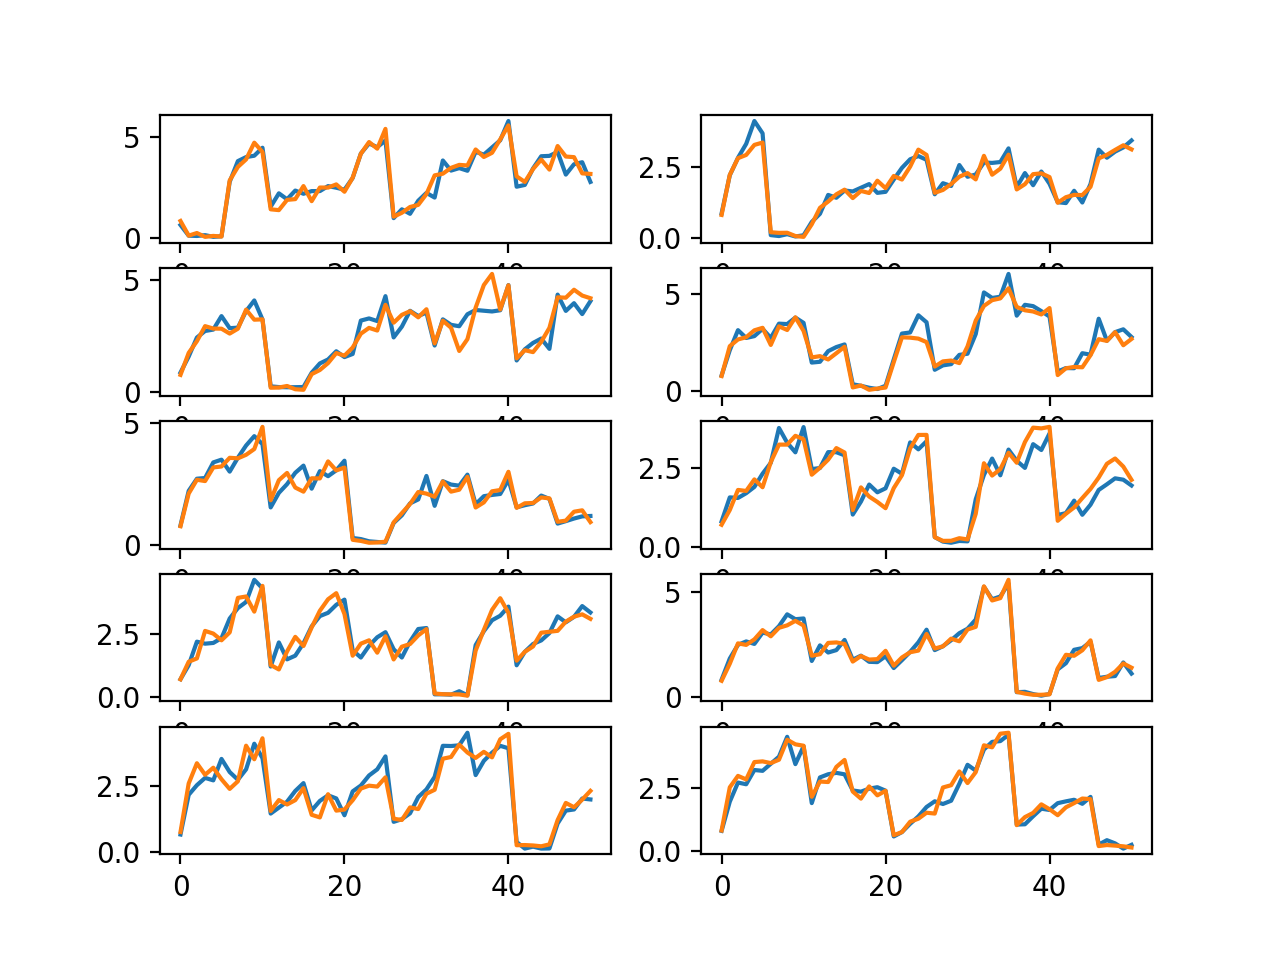

In [30]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_loss'][count])
        ax[r,c].plot(data_dict['valid_loss'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


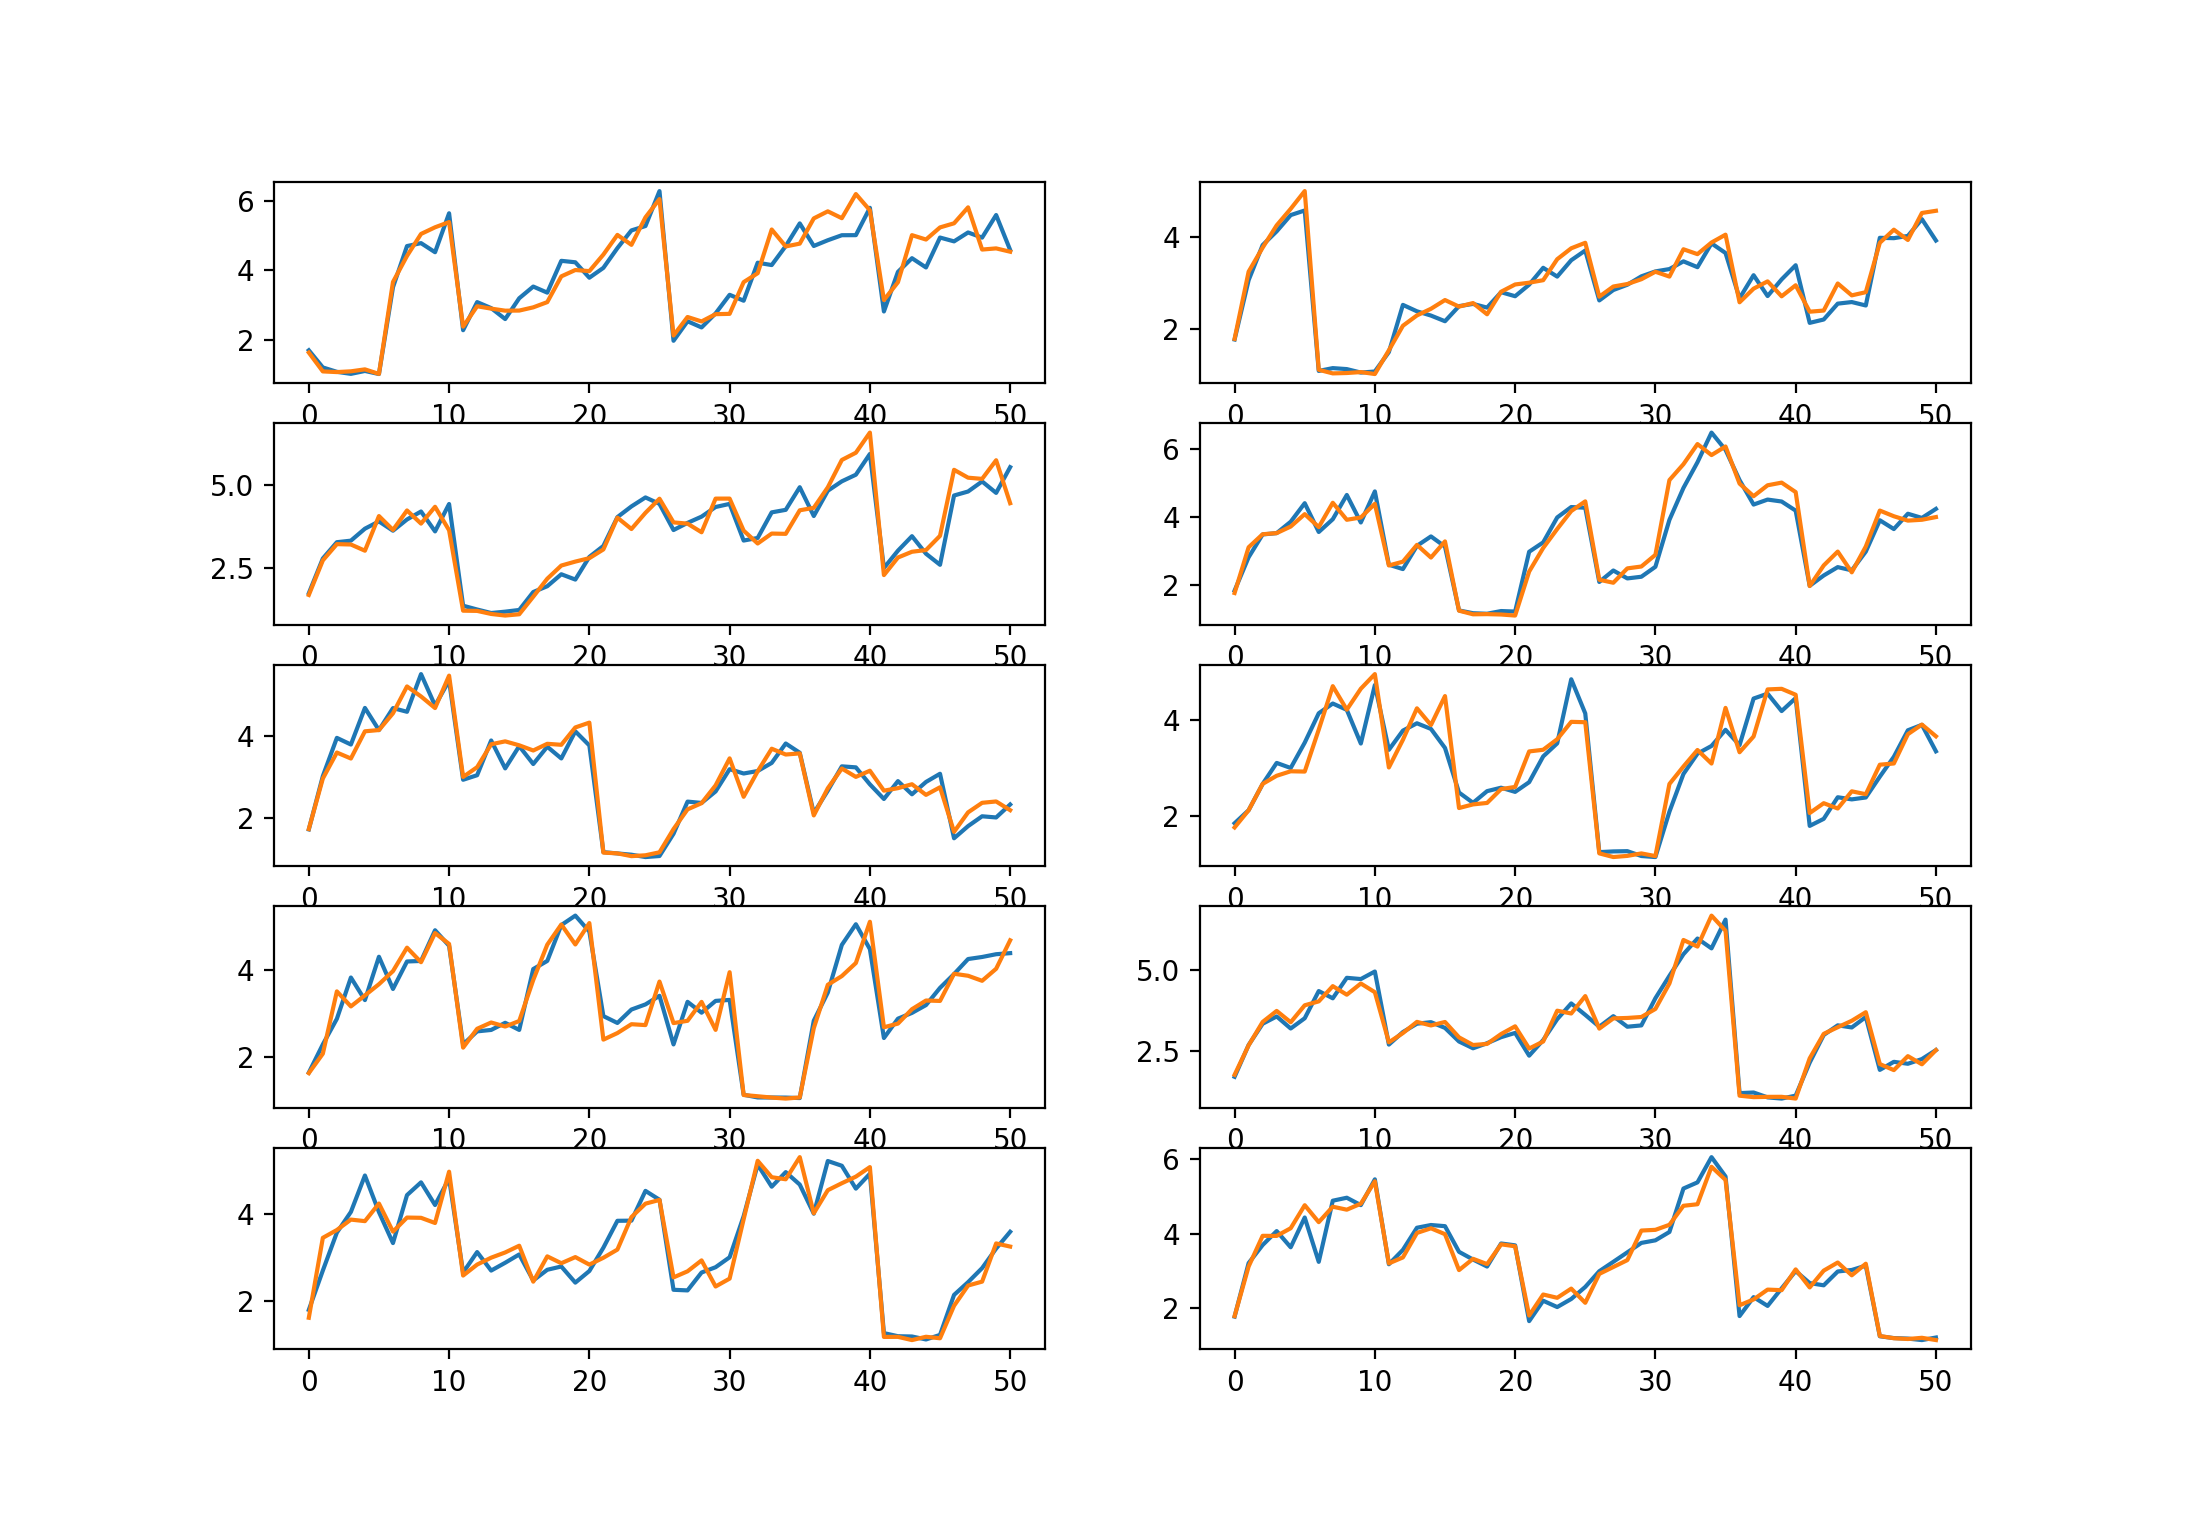

In [23]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_loss'][count])
        ax[r,c].plot(data_dict['valid_loss'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


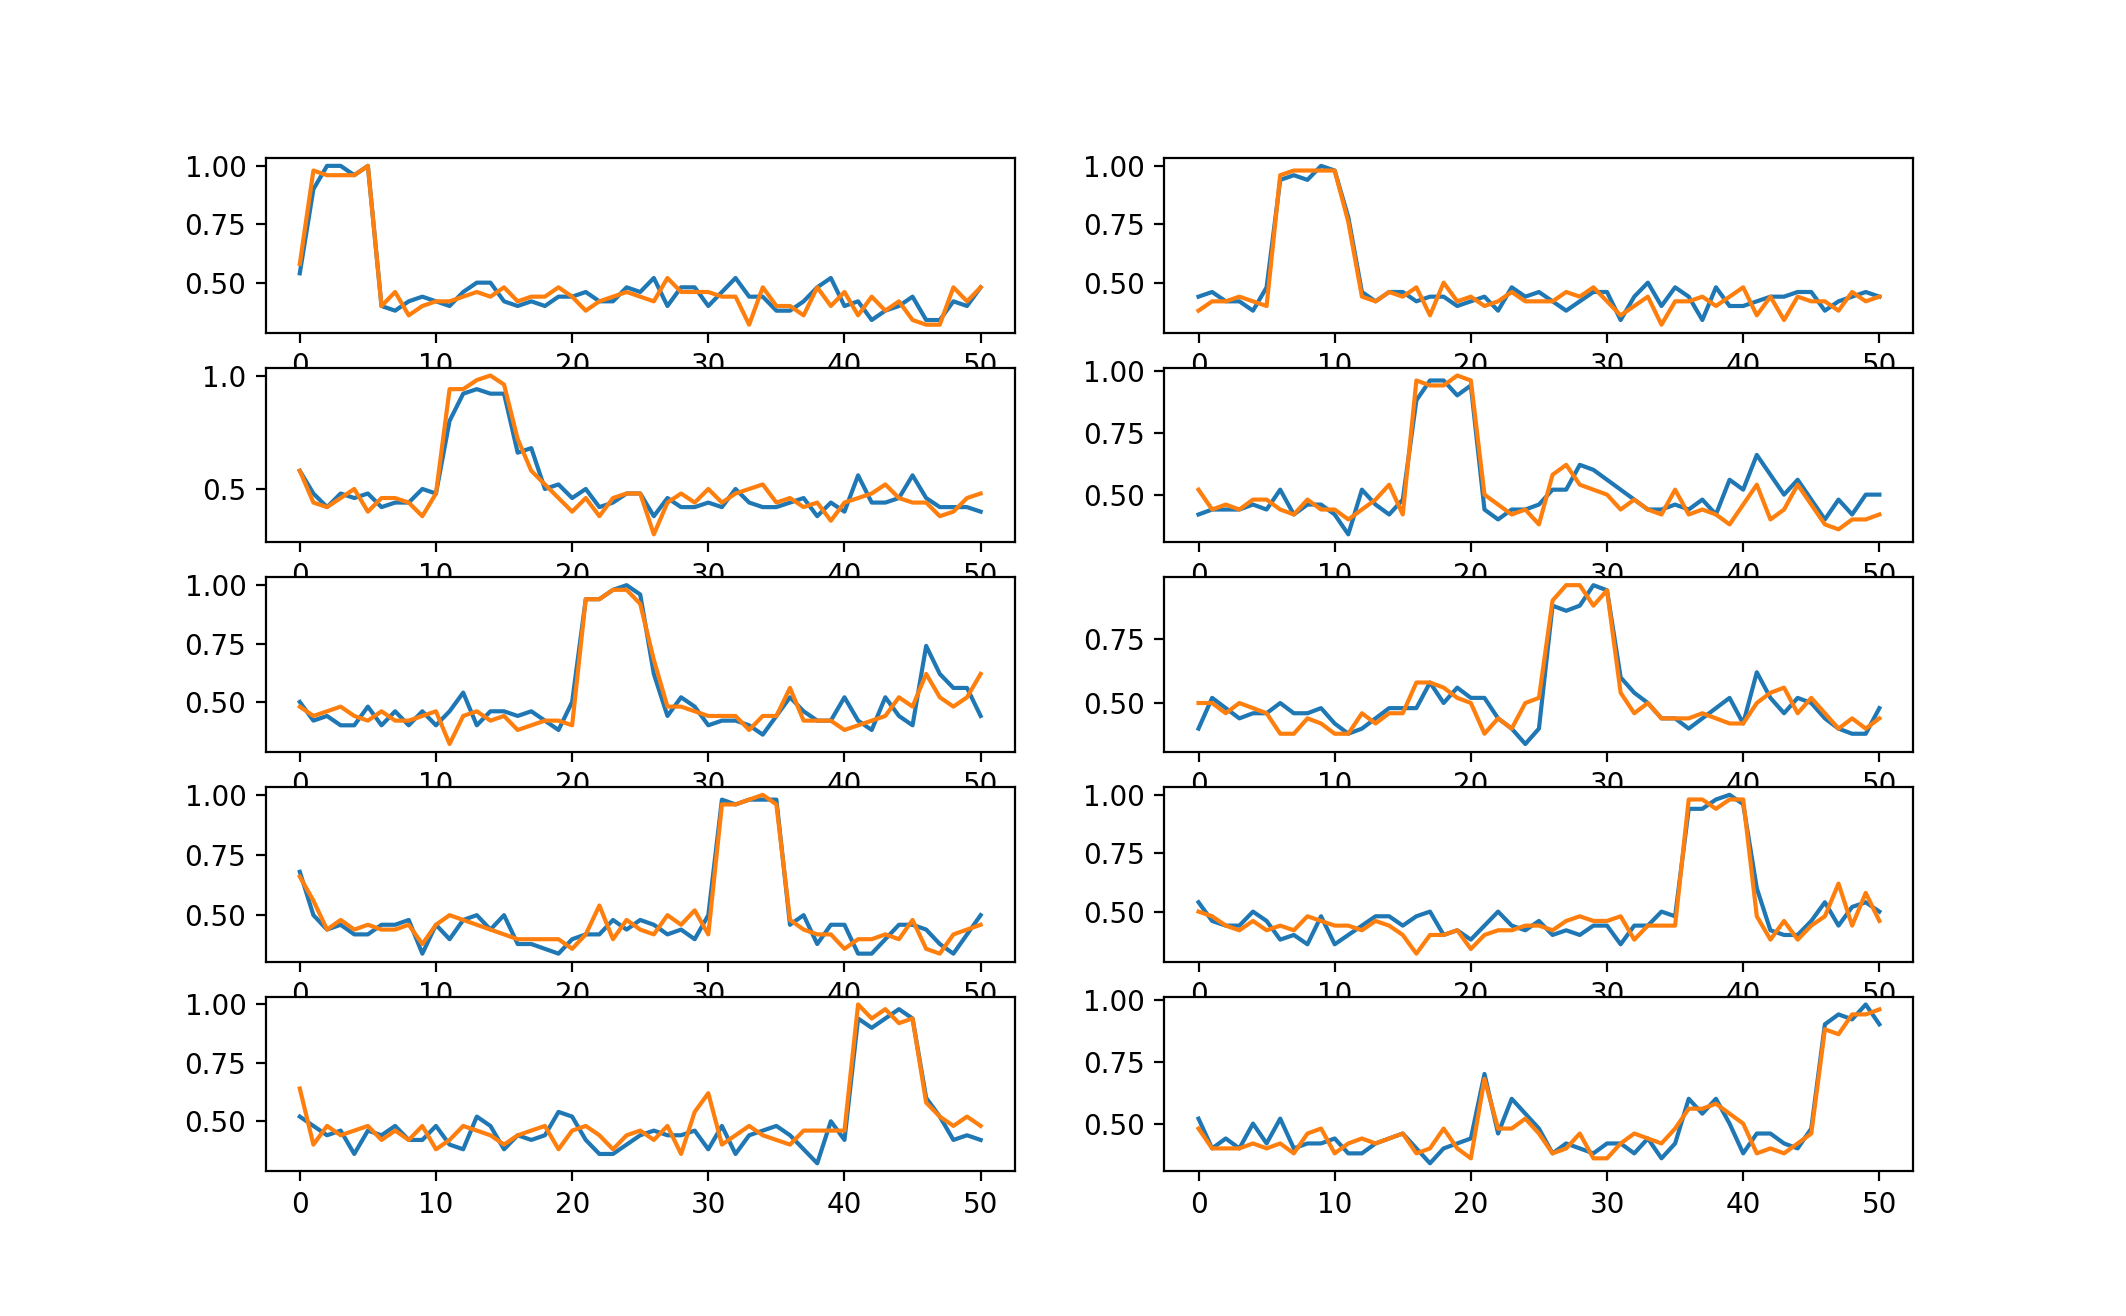

In [24]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_acc'][count])
        ax[r,c].plot(data_dict['valid_acc'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


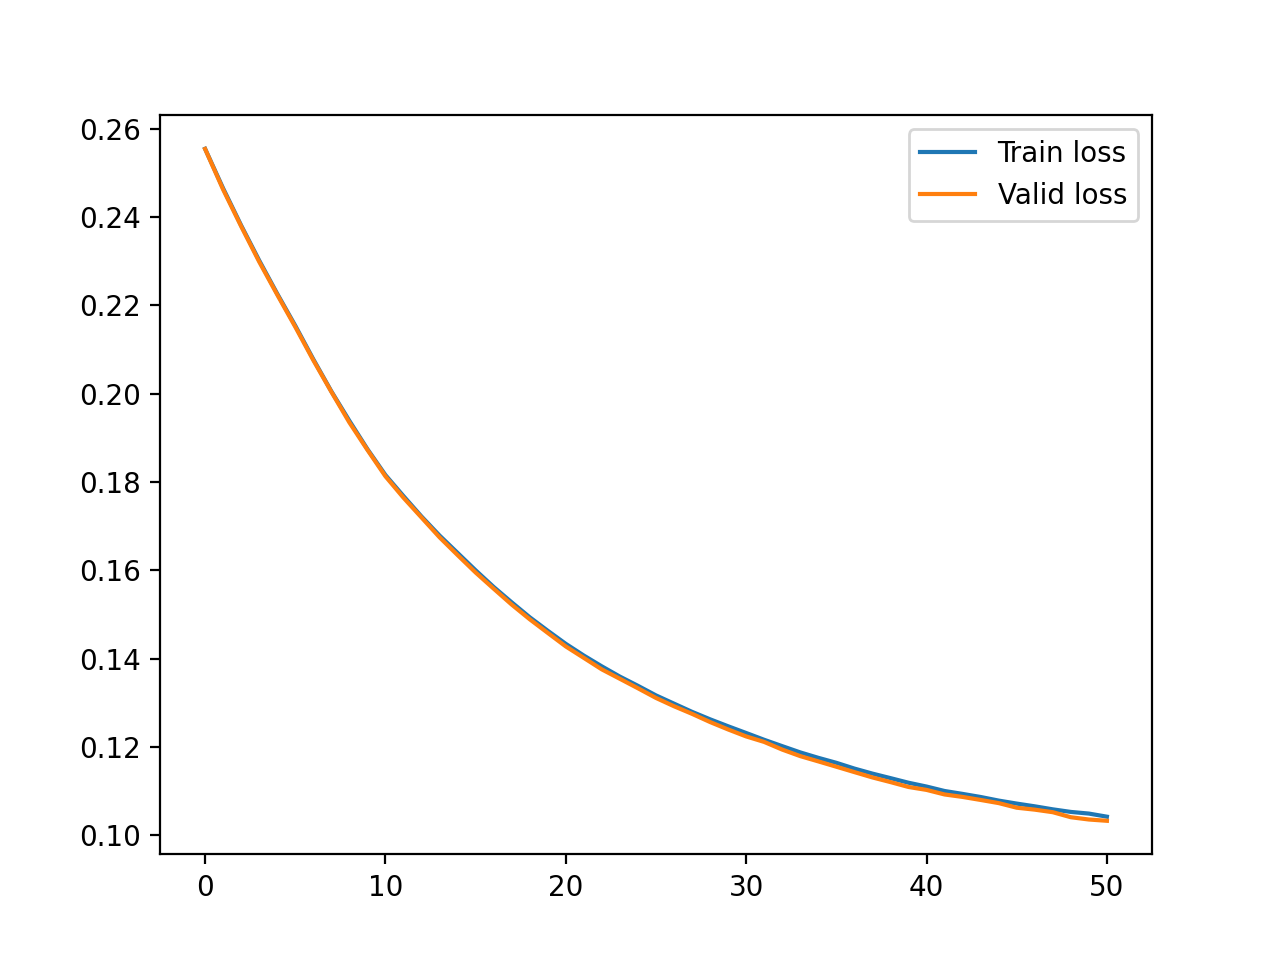

In [53]:
plt.plot(data_dict['train_autoencoder_loss'][0], label='Train loss')
plt.plot(data_dict['valid_autoencoder_loss'][0], label='Valid loss')
plt.legend(loc='upper right')
plt.show()